#### Пример с использованием XGBClassifier на игрушечном примере

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV

В этом игрушечном примере мы будем иметь дело с задачей двоичной классификации. Мы начинаем с создания 20-мерного искусственного набора данных с 1000 выборками, где 8 признаков содержат информацию, 3 являются избыточными и 2 повторяются. И выполните разделение трейн/тест. Данные тестирования будут полезны для проверки эффективности наших алгоритмов.

In [2]:
seed = 104
X, y = make_classification(n_samples=1000, n_features=20, 
                           n_informative=8, n_redundant=3, 
                           n_repeated=2, random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print('Train label distribution:')
print(np.bincount(y_train))

print('\nTest label distribution:')
print(np.bincount(y_test))

Train label distribution:
[396 404]

Test label distribution:
[106  94]


In [3]:
tree = DecisionTreeClassifier(random_state=seed, max_depth=6)

tree.fit(X_train, y_train)

tree_y_pred = tree.predict(X_test)
tree_y_pred_prob = tree.predict_proba(X_test)[:, 1]

tree_auc = roc_auc_score(y_test, tree_y_pred_prob)
print('auc:', tree_auc)

auc: 0.8474006423123244


In [4]:
xgb_params_fixed = {
    'learning_rate': 0.1,
    'objective': 'binary:logistic', # use 'multi:softprob' for multi-class problems
    'max_depth': 6, # length of the longest path from a root to a leaf
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing each tree
    'max_delta_step': 1, 
    'n_estimators': 150,
    'n_jobs': -1 # use all possible cores for training
}
model_xgb = XGBClassifier(**xgb_params_fixed, eval_metric='auc')

eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=6, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

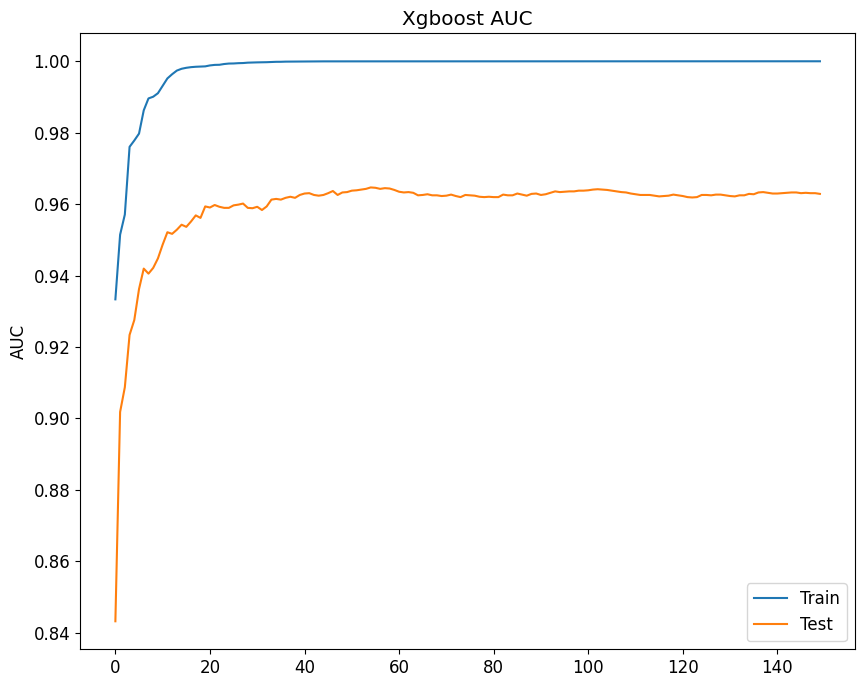

In [5]:
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


history = model_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc='best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

Судя по нашему графику, похоже, что есть возможность остановить процесс обучения на более раннем этапе, поскольку показатель AUC набора тестовых данных перестал увеличиваться примерно у 80 оценщиков. К счастью, xgboost поддерживает эту функцию.

Ранняя остановка работает путем мониторинга производительности модели, которая обучается на отдельном наборе проверочных данных, и остановки процедуры обучения, как только производительность в наборе проверочных данных не улучшится после фиксированного количества итераций обучения (мы можем указать это число). Это потенциально сэкономит нам много времени от обучения модели, производительность которой со временем не улучшится.

Мерой оценки может быть функция потерь, которая оптимизируется для обучения нашей модели (например, логарифмические потери), или внешняя метрика, представляющая интерес для проблемы в целом (например, оценка AUC, которую мы использовали выше). Полный список показателей производительности, которые мы можем указать напрямую, можно найти в разделе eval_metric документа XGBoost: Параметры задачи обучения.

Помимо указания метрики оценки и набора данных, чтобы использовать раннюю остановку, нам также необходимо указать раунды в нашей функции обратного вызова. По сути, это говорит нашей модели остановить процесс обучения, если метрика оценки набора оценочных данных не улучшится за такое количество раундов. Обратите внимание: если в списке указано несколько наборов данных оценки или несколько показателей оценки, то при ранней остановке будет использоваться последний в списке.

Например, мы можем проверить отсутствие улучшения AUC за 5 раундов следующим образом:

In [6]:
early_stop = EarlyStopping(rounds=5, save_best=True)
xgb_params_fixed['callbacks'] = [early_stop]
model_xgb = XGBClassifier(**xgb_params_fixed, eval_metric='auc')

model_xgb.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=10
)

print('best iteration', model_xgb.best_ntree_limit)

[0]	validation_0-auc:0.93333	validation_1-auc:0.84319
[10]	validation_0-auc:0.99316	validation_1-auc:0.94867
[20]	validation_0-auc:0.99884	validation_1-auc:0.95905
[30]	validation_0-auc:0.99969	validation_1-auc:0.95925
[31]	validation_0-auc:0.99971	validation_1-auc:0.95835
best iteration 28


In [7]:
# за счет этого результат уже стал лучше
y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

auc: 0.9601565636290647


In [8]:
# убедитесь, что мы можем сериализовать и десериализовать модель
model_checkpoint = 'model.xgb'
model_xgb.save_model(model_checkpoint)
model_xgb_loaded = XGBClassifier()
model_xgb_loaded.load_model(model_checkpoint)

y_pred_prob = model_xgb_loaded.predict_proba(X_test,)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

auc: 0.9601565636290647


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:761: UserWarning: callbacks is not saved in Scikit-Learn meta.
  warnings.warn(


In [9]:
def plot_xgboost_importance(xgboost_model, feature_names, threshold=5):
    
    # конвертируем словарь в кортежи и сортируем по
    # оценке важности в порядке возрастания для целей построения графика
    importance = xgboost_model.get_booster().get_score(importance_type='gain')
    tuples = [(int(k[1:]), importance[k]) for k in importance]
    tuples = sorted(tuples, key = itemgetter(1))
    labels, values = zip(*tuples)

    # сделать важность относительно максимальной важности,
    # и отфильтровать те, у которых меньше 5%
    # относительная важность (порог выбирается произвольно)
    labels, values = np.array(labels), np.array(values)
    values = np.round(100 * values / np.max(values), 2)
    mask = values > threshold
    labels, values = labels[mask], values[mask]
    feature_labels = feature_names[labels]

    ylocs = np.arange(values.shape[0])
    plt.barh(ylocs, values, align='center')
    for x, y in zip(values, ylocs):
        plt.text(x + 1, y, x, va='center')

    plt.ylabel('Features')
    plt.xlabel('Relative Importance Score')
    plt.title('Feature Importance Score')
    plt.xlim([0, 110])
    plt.yticks(ylocs, feature_labels)

    # revert the ordering of the importance
    return labels[::-1]

array([ 3, 17, 15,  2, 19, 13, 10,  9,  7,  1, 16,  6, 18, 12,  5,  4, 11,
       14,  8])

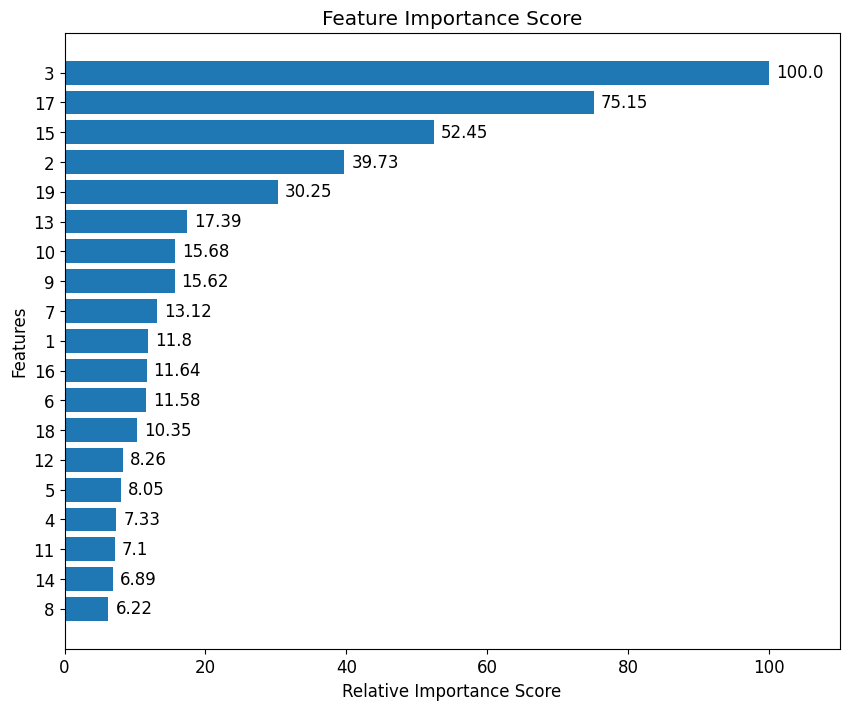

In [10]:
feature_names = np.arange(X_train.shape[1])
plot_xgboost_importance(xgboost_model=model_xgb, feature_names=feature_names)

Примечание: помимо использования встроенной метрики оценки, мы также можем определить ее самостоятельно. Метрикой оценки должна быть функция, которая принимает два аргумента y_pred, y_true (ее не обязательно называть так). Предполагается, что y_true будет объектом DMatrix, чтобы мы могли вызвать метод get_label для доступа к истинным меткам. Что касается возвращаемого значения, функция должна возвращать пару str, value, где str — это имя метрики оценки, а value — значение оценки. Эта цель всегда минимизируется.

In [11]:
def misclassified(y_pred, y_true):
    """
    custom evaluation metric for xgboost, the metric
    counts the number of misclassified examples assuming 
    that classes with p>0.5 are positive
    """
    labels = y_true.get_label() # obtain true labels
    preds = y_pred > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)


early_stop = EarlyStopping(rounds=5, save_best=True)
xgb_params_fixed['callbacks'] = [early_stop]
model_xgb = XGBClassifier(**xgb_params_fixed)
model_xgb.fit(
    X_train, y_train,
    eval_metric=misclassified,
    eval_set=eval_set,
    verbose=10
)

y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

[0]	validation_0-logloss:0.65370	validation_0-misclassified:69.00000	validation_1-logloss:0.66234	validation_1-misclassified:34.00000
[10]	validation_0-logloss:0.35626	validation_0-misclassified:33.00000	validation_1-logloss:0.41907	validation_1-misclassified:21.00000
[18]	validation_0-logloss:0.22262	validation_0-misclassified:20.00000	validation_1-logloss:0.32488	validation_1-misclassified:20.00000
auc: 0.9528301886792453


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Если модель xgboost слишком сложна, мы можем попробовать:

- Уменьшите max_depth, глубину каждого дерева.
- Увеличьте min_child_weight, минимальную сумму веса наблюдения, необходимой для ребенка (думайте об этом как о количестве наблюдений, необходимых в узле дерева).
- Увеличьте gamma, минимальное снижение потерь, необходимое для дальнейшего разбиения.
- Включить регуляризационные параметры, reg_lambda (l2 regularization) and reg_alpha (l1 regularization).

In [12]:
def build_xgboost(X_train, y_train, X_test, y_test, n_iter):
    
    early_stop = EarlyStopping(rounds=5, save_best=True)
    xgb_param_fixed = {        
        'max_delta_step': 1,
        'n_jobs': -1,
        'n_estimators': 300,
        'learning_rate': 0.1,
        'callbacks': [early_stop]
    }
    xgb_base = XGBClassifier(**xgb_param_fixed, eval_metric='auc')

    xgb_param_options = {
        'max_depth': randint(low=3, high=15),
        'colsample_bytree': uniform(loc=0.7, scale=0.3),
        'subsample': uniform(loc=0.7, scale=0.3)}
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    early_stop = EarlyStopping(rounds=5, save_best=True)
    xgb_fit_params = {   
         
        'eval_set': eval_set,
        'verbose': False
    }

    model_xgb = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=xgb_param_options,
        cv=10,   
        n_iter=n_iter,
        n_jobs=1,
        verbose=1
    ).fit(X_train, y_train, **xgb_fit_params)
    
    print('Best score obtained: {0}'.format(model_xgb.best_score_))
    print('Best Parameters:')
    for param, value in model_xgb.best_params_.items():
        print('\t{}: {}'.format(param, value))

    return model_xgb.best_estimator_

In [13]:
xgb_model = build_xgboost(X_train, y_train, X_test, y_test, n_iter=15)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
print('auc:', roc_auc_score(y_test, y_pred_prob))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best score obtained: 0.9025000000000001
Best Parameters:
	colsample_bytree: 0.7938162772204346
	max_depth: 10
	subsample: 0.8183985784644427
auc: 0.9630670413488559
